In [67]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


In [68]:
exchange = ccxt.binance()

ohlcv_data = exchange.fetch_ohlcv(symbol='BTCUSDT', timeframe='1d', limit=1000)

df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

df['date'] = pd.to_datetime(df['timestamp'], unit='ms')

print(df.head())


       timestamp      open      high       low     close         volume  \
0  1622246400000  35661.79  37338.58  33632.76  34605.15  112663.092689   
1  1622332800000  34605.15  36488.00  33379.00  35641.27   73535.386967   
2  1622419200000  35641.26  37499.00  34153.84  37253.81   94160.735289   
3  1622505600000  37253.82  37894.81  35666.00  36693.09   81234.663770   
4  1622592000000  36694.85  38225.00  35920.00  37568.68   67587.372495   

        date  
0 2021-05-29  
1 2021-05-30  
2 2021-05-31  
3 2021-06-01  
4 2021-06-02  


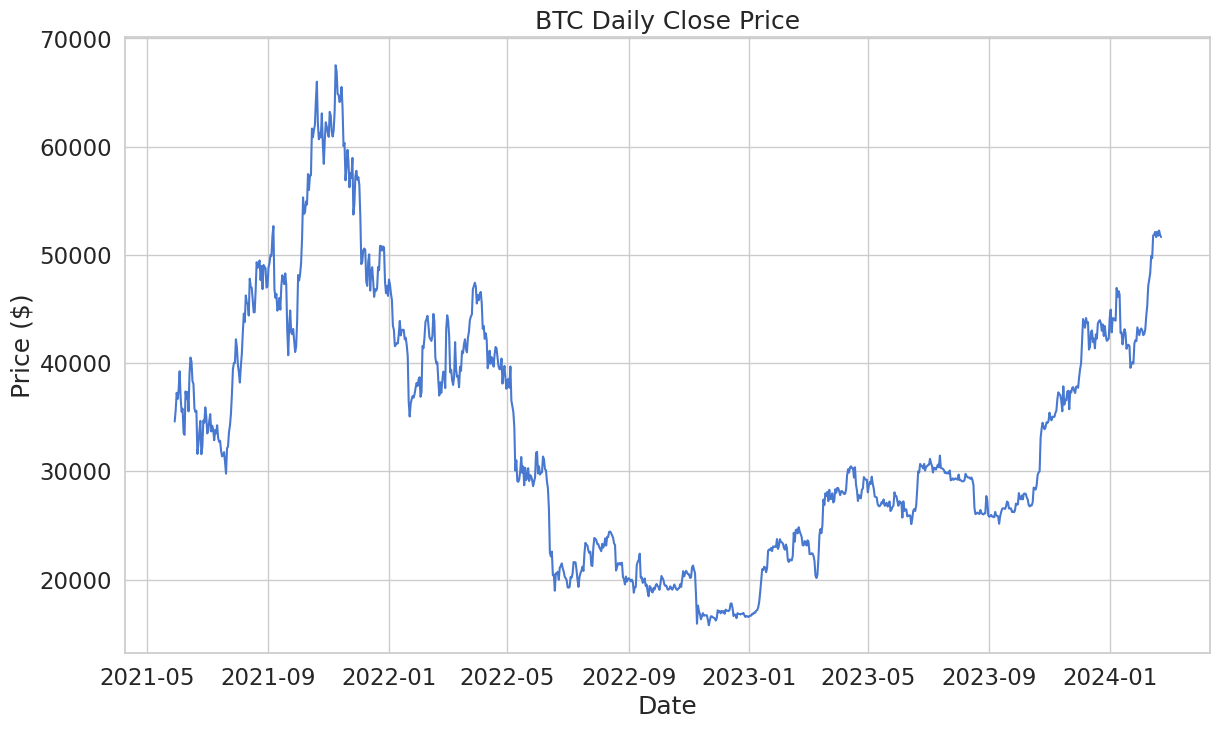

In [69]:

plt.rcParams['figure.figsize'] = (14, 8)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

ax = sns.lineplot(x='date', y='close', data=df)

ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('BTC Daily Close Price')
plt.show()


In [70]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1,1)

scaled_closed=scaler.fit_transform(close_price)

In [71]:
# Veriyi belirtilen uzunlukta (seg_len) sekanslara bölen bir fonksiyon
def split_into_sequences(data, seg_len):
    n_seg = len(data) - seg_len + 1
    return np.array([data[i:(i + seg_len)] for i in range(n_seg)])

# Eğitim ve test setlerini oluşturan bir fonksiyon
def get_train_test_sets(data, seg_len, train_frac):
    scaled_closed = data.reshape(-1, 1)  # Veriyi düzenleme
    # Veriyi belirtilen uzunlukta sekanslara bölme
    sequences = split_into_sequences(scaled_closed, seg_len)
    
    # Eğitim seti boyutunu belirleme
    n_train = int(len(sequences) * train_frac)
    
    # Eğitim verileri ve etiketleri
    x_train = sequences[:n_train, :-1]
    y_train = sequences[:n_train, -1]
    
    # Test verileri ve etiketleri
    x_test = sequences[n_train:, :-1]
    y_test = sequences[n_train:, -1]
    
    return x_train, y_train, x_test, y_test

scaled_closed = np.random.rand(100) 
seg_len = 60
x_train, y_train, x_test, y_test = get_train_test_sets(scaled_closed, seg_len, train_frac=0.9)


In [72]:
from tensorflow import keras
from tensorflow.keras.layers  import Bidirectional , Dropout , Activation , LSTM , Dense
from tensorflow.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [73]:
from keras.utils import plot_model


dropout = 0.2
window_size = seg_len - 1

model = Sequential()
model.add(LSTM(window_size , return_sequences= True , input_shape=(window_size,x_train.shape[-1])))
model.add(Dropout(dropout))
model.add(Bidirectional(LSTM((window_size * 2 ), return_sequences=True)))
model.add(Dropout(dropout))
model.add(Bidirectional(LSTM(window_size, return_sequences=True)))
model.add(Dense(units = 1))
model.add(Activation('linear'))

model.compile(optimizer='adam', loss='mean_squared_error',metrics= 'accuracy')

model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 59, 59)            14396     
                                                                 
 dropout_9 (Dropout)         (None, 59, 59)            0         
                                                                 
 bidirectional_10 (Bidirect  (None, 59, 236)           168032    
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 59, 236)           0         
                                                                 
 bidirectional_11 (Bidirect  (None, 59, 118)           139712    
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, 59, 1)            

In [74]:
model.fit(x_train, y_train, epochs=10, batch_size=10, shuffle=False , validation_split=0.2)

Epoch 1/10


3/3 [==============================] - 11s 1s/step - loss: 0.2417 - accuracy: 0.0000e+00 - val_loss: 0.3789 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 0s 115ms/step - loss: 0.1285 - accuracy: 0.0000e+00 - val_loss: 0.1929 - val_accuracy: 0.0000e+00
Epoch 3/10
3/3 [==============================] - 0s 115ms/step - loss: 0.0924 - accuracy: 0.0000e+00 - val_loss: 0.0997 - val_accuracy: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 0s 116ms/step - loss: 0.0938 - accuracy: 0.0000e+00 - val_loss: 0.1224 - val_accuracy: 0.0000e+00
Epoch 5/10
3/3 [==============================] - 0s 123ms/step - loss: 0.0682 - accuracy: 0.0000e+00 - val_loss: 0.2210 - val_accuracy: 0.0000e+00
Epoch 6/10
3/3 [==============================] - 0s 119ms/step - loss: 0.0800 - accuracy: 0.0000e+00 - val_loss: 0.2231 - val_accuracy: 0.0000e+00
Epoch 7/10
3/3 [==============================] - 0s 121ms/step - loss: 0.0747 - accuracy: 0.0000e+00 - val_loss: 0.1505 - va

In [ ]:
# Yukarıda belirtildiği gibi, y_test ve y_pred'in orijinal ölçeklerine dönmeleri gerekiyor
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# Orijinal ölçekteki verilerle grafiği çizme
plt.plot(y_test_orig, label='Actual Price', color='orange')
plt.plot(y_pred_orig, label='Predicted price', color='green')
plt.title("BTC Price Prediction")
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend(loc='best')
plt.show()